

```
Arup(4/21): Please do that for the first time only before running python project in colab
In order to access a shared with you folder or file in Google Colab you have to:

1.   Go to Shared with me in Google Drive.
2.   Select the folder or file you want to acess.
3.   Right click on it and choose Add shortcut to drive.
4.   A pop-up window will apear, Select MyDrive then click on Add Shortcut.
5.   Now, Go to your Google Colab Notebook 
6.   Go to edit --> Notebook Settting--> Hardware Acceleration: GPU
7.   Mount to Google Drive with below commands

```



To access data and model files

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive/',force_remount=True)
!ln -s "/gdrive/My Drive/ML Final Project/Code" 

Mounted at /content/drive/


In [ ]:
!pip install hyperas

Original Code Below, should only be run once to save optimal parameters

In [ ]:
"""
This network uses the last 26 observations of gwl, tide, and rain to predict the next 18
values of gwl for well MMPS-043
"""

import pandas as pd
from pandas import DataFrame
from pandas import concat
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import keras
import keras.backend as K
#from tensorflow.compat.v1.keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Dropout, LSTM
from keras.layers import Activation
#from keras.utils import plot_model, np_utils
from keras.utils.vis_utils import plot_model
from keras.regularizers import L1L2
from hyperas import optim
from hyperas.distributions import choice, uniform
#from hyperas.distributions import choice, uniform, conditional
from hyperopt import Trials, STATUS_OK, tpe
from math import sqrt
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import random as rn
import os
import torch
matplotlib.rcParams.update({'font.size': 8})

In [ ]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


def mse(y_true, y_pred):
    return K.mean(K.square(y_pred - y_true), axis=-1)


def mae(y_true, y_pred):
    return K.mean(K.abs(y_pred - y_true), axis=-1)


def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))


def data():
    def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
        n_vars = 1 if type(data) is list else data.shape[1]
        df = DataFrame(data)
        cols, names = list(), list()
        for i in range(n_in, 0, -1):
            cols.append(df.shift(i))
            names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
        for i in range(0, n_out):
            cols.append(df.shift(-i))
            if i == 0:
                names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
            else:
                names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
        agg = concat(cols, axis=1)
        agg.columns = names
        if dropnan:
            agg.dropna(inplace=True)
        return agg

    n_lags = 26
    n_ahead = 19
    n_train = 49563

    dataset_raw = read_csv("/content/drive/MyDrive/ML Final Project/Code/MMPS_043_no_blanks.csv",
                           index_col=None, parse_dates=True, infer_datetime_format=True)

    train_dates = dataset_raw[['Datetime', 'GWL', 'Tide', 'Precip.Avg']].iloc[:n_train]
    test_dates = dataset_raw[['Datetime', 'GWL', 'Tide', 'Precip.Avg']].iloc[n_train:]
    test_dates = test_dates.reset_index(drop=True)
    test_dates['Datetime'] = pd.to_datetime(test_dates['Datetime'])

    dataset = dataset_raw.drop(dataset_raw.columns[[0, 3, 4, 5, 6]], axis=1)

    values = dataset.values
    values = values.astype('float32')

    gwl = values[:, 0]
    gwl = gwl.reshape(gwl.shape[0], 1)

    tide = values[:, 1]
    tide = tide.reshape(tide.shape[0], 1)

    rain = values[:, 2]
    rain = rain.reshape(rain.shape[0], 1)

    gwl_scaler, tide_scaler, rain_scaler = MinMaxScaler(), MinMaxScaler(), MinMaxScaler()
    gwl_scaled = gwl_scaler.fit_transform(gwl)
    tide_scaled = tide_scaler.fit_transform(tide)
    rain_scaled = rain_scaler.fit_transform(rain)

    gwl_super = series_to_supervised(gwl_scaled, n_lags, n_ahead)
    gwl_super_values = gwl_super.values
    tide_super = series_to_supervised(tide_scaled, n_lags, n_ahead)
    tide_super_values = tide_super.values
    rain_super = series_to_supervised(rain_scaled, n_lags, n_ahead)
    rain_super_values = rain_super.values

    gwl_input, gwl_labels = gwl_super_values[:, 0:n_lags + 1], gwl_super_values[:, n_lags + 1:]

    train_X = np.concatenate((gwl_input[:n_train, :], tide_super_values[:n_train, :], rain_super_values[:n_train, :]),
                             axis=1)
    test_X = np.concatenate((gwl_input[49563:56797, :], tide_super_values[49563:56797, :], rain_super_values[49563:56797, :]),
                            axis=1)
    train_y, test_y = gwl_labels[:n_train, :], gwl_labels[49563:56797, :]

    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    #helper function to do jittering in training data
    print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    return train_X, train_y, test_X, test_y, gwl_scaler, test_dates


def create_model(train_X, train_y, test_X, test_y):
    def rmse(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))

    n_ahead = 19
    n_test = 7548
    n_epochs = 1000
    n_neurons = 10
    n_batch = 49563

    os.environ['PYTHONHASHSEED'] = '0'
    np.random.seed(42)
    rn.seed(12345)
    session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    tf.compat.v1.set_random_seed(1234)
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    #K.set_session(sess)
    tf.compat.v1.keras.backend.set_session(sess) 
    
    model = Sequential()
    model.add(LSTM(units={{choice([10, 15, 20, 40, 50, 75])}}, activation={{choice(['relu', 'tanh', 'sigmoid'])}},
                   input_shape=(train_X.shape[1], train_X.shape[2]), use_bias=True,
                   bias_regularizer=L1L2(l1=0.01, l2=0.01)))
    model.add(Dropout({{uniform(0.1, 0.5)}}))
    model.add(Dense(activation='linear', units=n_ahead-1, use_bias=True))

    adam = tf.keras.optimizers.Adam(lr={{choice([10 ** -3, 10 ** -2, 10 ** -1])}})
    rmsprop = tf.keras.optimizers.RMSprop(lr={{choice([10 ** -3, 10 ** -2, 10 ** -1])}})
    sgd = tf.keras.optimizers.SGD(lr={{choice([10 ** -3, 10 ** -2, 10 ** -1])}})

    choiceval = {{choice(['adam', 'gsd', 'rmsprop'])}}
    if choiceval == 'adam':
        optim = adam
    elif choiceval == 'rmsprop':
        optim = rmsprop
    else:
        optim = sgd

    model.compile(loss=rmse, optimizer=optim)

    earlystop = keras.callbacks.EarlyStopping(monitor='loss', min_delta=0.00000001, patience=5, verbose=1, mode='auto')
    model.fit(train_X, train_y, batch_size=n_batch, epochs=n_epochs, verbose=2, shuffle=False, callbacks=[earlystop])
    loss = model.evaluate(test_X, test_y, batch_size=n_test, verbose=0)
    return {'loss': loss, 'status': STATUS_OK, 'model': model}


if __name__ == '__main__':
    n_ahead = 19
    n_lags = 26

    path = "/content/drive/MyDrive/ML Final Project/Code/"

    best_run, best_model = optim.minimize(model=create_model, data=data, algo=tpe.suggest, max_evals=100, trials=Trials(), notebook_name='/drive/MyDrive/ML Final Project/Code/MLFinalProject')
    train_X, train_y, test_X, test_y, gwl_scaler, test_dates = data()
    best_model.save('/content/drive/MyDrive/ML Final Project/Code/best_model_so_far') # save best model, so we don't have to run optimize code again or fit the model
    print("Best performing model chosen hyper-parameters:")
    print(best_run)


>>> Imports:
#coding=utf-8

try:
    from google.colab import drive
except:
    pass

try:
    from google.colab import drive
except:
    pass

try:
    import pandas as pd
except:
    pass

try:
    from pandas import DataFrame
except:
    pass

try:
    from pandas import concat
except:
    pass

try:
    from pandas import read_csv
except:
    pass

try:
    from sklearn.metrics import mean_squared_error
except:
    pass

try:
    from sklearn.preprocessing import MinMaxScaler
except:
    pass

try:
    import tensorflow as tf
except:
    pass

try:
    import keras
except:
    pass

try:
    import keras.backend as K
except:
    pass

try:
    from tensorflow.compat.v1.keras import backend as K
except:
    pass

try:
    from keras.models import Sequential
except:
    pass

try:
    from keras.layers import Dense, SimpleRNN, Dropout, LSTM
except:
    pass

try:
    from keras.layers import Activation
except:
    pass

try:
    from keras.utils.vis_utils import plot_model
except:
  

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)



Streaming output truncated to the last 5000 lines.
Epoch 573/1000

1/1 - 0s - loss: 0.4928 - 49ms/epoch - 49ms/step

Epoch 574/1000

1/1 - 0s - loss: 0.4908 - 49ms/epoch - 49ms/step

Epoch 575/1000

1/1 - 0s - loss: 0.4895 - 65ms/epoch - 65ms/step

Epoch 576/1000

1/1 - 0s - loss: 0.4881 - 63ms/epoch - 63ms/step

Epoch 577/1000

1/1 - 0s - loss: 0.4868 - 84ms/epoch - 84ms/step

Epoch 578/1000

1/1 - 0s - loss: 0.4853 - 65ms/epoch - 65ms/step

Epoch 579/1000

1/1 - 0s - loss: 0.4841 - 69ms/epoch - 69ms/step

Epoch 580/1000

1/1 - 0s - loss: 0.4827 - 65ms/epoch - 65ms/step

Epoch 581/1000

1/1 - 0s - loss: 0.4819 - 55ms/epoch - 55ms/step

Epoch 582/1000

1/1 - 0s - loss: 0.4801 - 66ms/epoch - 66ms/step

Epoch 583/1000

1/1 - 0s - loss: 0.4789 - 64ms/epoch - 64ms/step

Epoch 584/1000

1/1 - 0s - loss: 0.4772 - 51ms/epoch - 51ms/step

Epoch 585/1000

1/1 - 0s - loss: 0.4760 - 56ms/epoch - 56ms/step

Epoch 586/1000

1/1 - 0s - loss: 0.4741 - 56ms/epoch - 56ms/step

Epoch 587/1000

1/1 - 0s 

# New Section

Load optimal model

In [ ]:
#using best model above
#100 evals {'Dropout': 0.24505392260227796, 'activation': 1,'choiceval': 0, 'lr': 0, 'lr_1': 2, 'lr_2': 0, 'units': 5} 
#Best performing model chosen hyper-parameters:{'Dropout': 0.1394143626335395, 'activation': 1, 'choiceval': 2, 'lr': 2, 'lr_1': 0, 'lr_2': 0, 'units': 1}
def rmse(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))
model = keras.models.load_model('/content/drive/MyDrive/ML Final Project/Code/best_model_so_far', custom_objects={'rmse': rmse})#retrieves saved best model


Retrieve Data

In [ ]:
#retrieve data
def data():
    def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
        n_vars = 1 if type(data) is list else data.shape[1]
        df = DataFrame(data)
        cols, names = list(), list()
        for i in range(n_in, 0, -1):
            cols.append(df.shift(i))
            names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
        for i in range(0, n_out):
            cols.append(df.shift(-i))
            if i == 0:
                names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
            else:
                names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
        agg = concat(cols, axis=1)
        agg.columns = names
        if dropnan:
            agg.dropna(inplace=True)
        return agg

    n_lags = 26
    n_ahead = 19
    n_train = 49563

    dataset_raw = read_csv("/content/drive/MyDrive/ML Final Project/Code/MMPS_043_no_blanks.csv",
                           index_col=None, parse_dates=True, infer_datetime_format=True)

    train_dates = dataset_raw[['Datetime', 'GWL', 'Tide', 'Precip.Avg']].iloc[:n_train]
    test_dates = dataset_raw[['Datetime', 'GWL', 'Tide', 'Precip.Avg']].iloc[n_train:]
    test_dates = test_dates.reset_index(drop=True)
    test_dates['Datetime'] = pd.to_datetime(test_dates['Datetime'])

    dataset = dataset_raw.drop(dataset_raw.columns[[0, 3, 4, 5, 6]], axis=1)

    values = dataset.values
    values = values.astype('float32')

    gwl = values[:, 0]
    gwl = gwl.reshape(gwl.shape[0], 1)

    tide = values[:, 1]
    tide = tide.reshape(tide.shape[0], 1)

    rain = values[:, 2]
    rain = rain.reshape(rain.shape[0], 1)

    gwl_scaler, tide_scaler, rain_scaler = MinMaxScaler(), MinMaxScaler(), MinMaxScaler()
    gwl_scaled = gwl_scaler.fit_transform(gwl)
    tide_scaled = tide_scaler.fit_transform(tide)
    rain_scaled = rain_scaler.fit_transform(rain)

    gwl_super = series_to_supervised(gwl_scaled, n_lags, n_ahead)
    gwl_super_values = gwl_super.values
    tide_super = series_to_supervised(tide_scaled, n_lags, n_ahead)
    tide_super_values = tide_super.values
    rain_super = series_to_supervised(rain_scaled, n_lags, n_ahead)
    rain_super_values = rain_super.values

    gwl_input, gwl_labels = gwl_super_values[:, 0:n_lags + 1], gwl_super_values[:, n_lags + 1:]

    train_X = np.concatenate((gwl_input[:n_train, :], tide_super_values[:n_train, :], rain_super_values[:n_train, :]),
                             axis=1)
    test_X = np.concatenate((gwl_input[49563:56797, :], tide_super_values[49563:56797, :], rain_super_values[49563:56797, :]),
                            axis=1)
    train_y, test_y = gwl_labels[:n_train, :], gwl_labels[49563:56797, :]

    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    return train_X, train_y, test_X, test_y, gwl_scaler, test_dates

train_X, train_y, test_X, test_y, gwl_scaler, test_dates = data()

model.fit(train_X, train_y)

(49563, 1, 117) (49563, 18) (7234, 117) (7234, 18)
1549/1549 [==============================] - 16s 6ms/step - loss: 0.0261


Calculate Errors

In [ ]:
def mse(y_true, y_pred):
    return K.mean(K.square(y_pred - y_true), axis=-1)


def mae(y_true, y_pred):
    return K.mean(K.abs(y_pred - y_true), axis=-1)



y_pred = model.predict(test_X)
print("MSE: ")
print(mse(test_y, y_pred))
px = pd.DataFrame(mse(test_y, y_pred).numpy())
print("Mean of MSE tensor:")
print(px.mean(0))
print("MAE: ")
print(mae(test_y, y_pred))
print("Mean of MAE tensor:")
print("RMSE: ")
print(rmse(test_y, y_pred))
print("Mean of RMSE tensor:")


MSE: 
tf.Tensor(
[1.7083762e-03 1.5382068e-03 1.4504511e-03 ... 1.1035486e-05 8.5380307e-06
 5.5099740e-06], shape=(7234,), dtype=float32)
Mean of MSE tensor:
0    0.000851
dtype: float32
MAE: 
tf.Tensor([0.0407388  0.03864921 0.03757023 ... 0.00250183 0.00225228 0.00197844], shape=(7234,), dtype=float32)
Mean of MAE tensor:
RMSE: 
tf.Tensor([0.04133251 0.03921998 0.03808479 ... 0.00332197 0.00292199 0.00234733], shape=(7234,), dtype=float32)
Mean of RMSE tensor:


Plot Curve

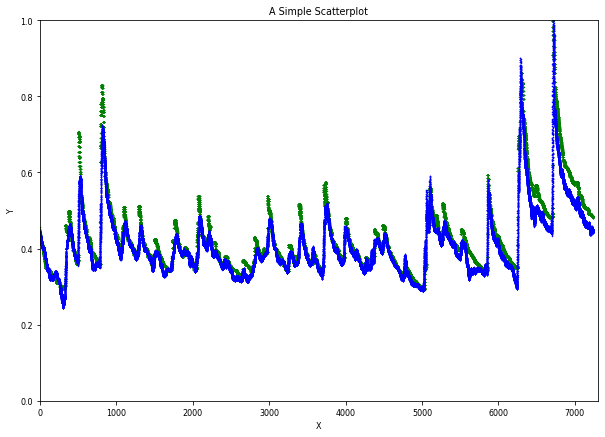

In [ ]:

x_axis = list(range(1, len(y_pred)+1))
plt.figure(figsize=(10,7)) # 10 is width, 7 is height
plt.plot(x_axis, test_y, 'g*', label='GreenDots', markersize=1)  # green dots
plt.plot(x_axis, y_pred, 'b*', label='Bluestars', markersize=1)  # blue stars
plt.title('A Simple Scatterplot')  
plt.xlabel('X')
plt.ylabel('Y')
plt.xlim(0, 7300)
plt.ylim(0, 1)
plt.show()